In [72]:
import tensorflow as tf
import numpy as np
from datasets import dataset_utils
import os
import glob
import matplotlib.pyplot as plt
import math
from collections import Counter
import scipy
from datetime import datetime
import time
from scipy.misc import imresize
from nets import inception 
from tensorflow.contrib import slim
import functools
import keras
import os
import re
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import pickle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.image as mpimg
from time import time
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras import activations
from keras.models import load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import initializers
from keras.models import Sequential, Model
from keras.applications import imagenet_utils
import h5py as h5py
from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
from vis.utils import utils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Base url
TF_MODELS_URL = "http://download.tensorflow.org/models/"
# CNN url
INCEPTION_V3_URL = TF_MODELS_URL + "inception_v3_2016_08_28.tar.gz"
# Directory to save model checkpoints
MODELS_DIR = "models/cnn"
INCEPTION_V3_CKPT_PATH = MODELS_DIR + "/inception_v3.ckpt"
# Make the model directory if it does not exist
if not tf.gfile.Exists(MODELS_DIR):
     tf.gfile.MakeDirs(MODELS_DIR)

# Download the appropriate model if haven't already done so
if not os.path.exists(INCEPTION_V3_CKPT_PATH): 
     dataset_utils.download_and_uncompress_tarball(INCEPTION_V3_URL, MODELS_DIR)

# 1. Dataset overview and preparation

In [3]:
DATASET_DIRECTORY = "MantaRay"

print(glob.glob(DATASET_DIRECTORY + '/*')[0].split('/')[1])

Heartbreaker


In [5]:
DATASET_DIRECTORY = "MantaRay"
individual_number = []
individuals = glob.glob(DATASET_DIRECTORY + '/*')
# Count number of photos of each individual. Individual number is a list of tuples 
# with each tuple composed of the name and the number of photos of an individual.
for i in individuals:
    photos_low = glob.glob(i + '/*_CR.jpg')
    photos_upper = glob.glob(i + '/*_CR.JPG')
    num_images = len(photos_low) + len(photos_upper)
    individual_number.append((i.split('/')[1], num_images))

In [6]:
len(individual_number)

265

In [7]:
individuals = []
number = []

for i in range(len(individual_number)):
    individuals.append(individual_number[i][0])
    number.append(individual_number[i][1])

In [8]:
np.mean(number)

2.7169811320754715

In [11]:
individual_number[:15]

[('Heartbreaker', 2),
 ('Apple', 2),
 ('Diamond', 2),
 ('Marietta', 3),
 ('Martini', 2),
 ('CandyCane', 2),
 ('2-Pac', 3),
 ('Chainsaw', 2),
 ('Geronimo', 2),
 ('Adrian', 2),
 ('Daniela', 3),
 ('Lame', 2),
 ('Copycat', 2),
 ('Voodoo', 1),
 ('Butterfly', 4)]

In [12]:
# Map each class (individual) to an integer label
class_mapping = {}
index = 0
class_images = {}
# Create dictionary to map integer labels to individuals
# Class_images will record number of images for each class
for directory in glob.glob(DATASET_DIRECTORY + '/*'):
    class_mapping[index] = directory.split("/")[1]
    class_images[index] = len(glob.glob(directory + '/*_CR.jpg')) + len(glob.glob(directory + '/*_CR.JPG'))
    index += 1

In [14]:
print(class_mapping)

{0: 'Heartbreaker', 1: 'Apple', 2: 'Diamond', 3: 'Marietta', 4: 'Martini', 5: 'CandyCane', 6: '2-Pac', 7: 'Chainsaw', 8: 'Geronimo', 9: 'Adrian', 10: 'Daniela', 11: 'Lame', 12: 'Copycat', 13: 'Voodoo', 14: 'Butterfly', 15: 'Xena', 16: 'Mee Mee', 17: 'Woodchuck', 18: 'Varkie', 19: 'Foxy', 20: 'Adone', 21: 'Easter', 22: 'Roo', 23: 'Adoption 709', 24: 'Blah', 25: 'Changeling', 26: 'Ms. Pac-Man', 27: 'Platty', 28: 'Lida', 29: 'Ani', 30: 'Linda', 31: 'Pony', 32: 'Oscar', 33: 'Sweet Pea', 34: 'Honk', 35: 'Crackle', 36: 'Radish', 37: 'Soldier', 38: 'Oddball', 39: 'Platypus', 40: 'C-Section', 41: 'Milkyway', 42: 'Possessive', 43: 'Rain', 44: 'Sharks-Tale', 45: 'Gonzales', 46: 'Leonie', 47: 'Moley', 48: 'Cheesy Time', 49: 'Myeisha', 50: 'Acne', 51: 'Cuttle', 52: 'Janella', 53: 'Scribble', 54: 'Moby Dick', 55: 'Shotgun', 56: 'Midnight', 57: 'Flake', 58: 'Manta 1', 59: 'Rubix Cube', 60: 'Apostrophe', 61: 'Prudence', 62: 'Manx', 63: 'San Ben Giant Manta', 64: 'Karate', 65: 'New Moon', 66: 'Bok', 6

In [40]:
print(class_images)

{0: 2, 1: 2, 2: 2, 3: 3, 4: 2, 5: 2, 6: 3, 7: 2, 8: 2, 9: 2, 10: 3, 11: 2, 12: 2, 13: 1, 14: 4, 15: 4, 16: 2, 17: 3, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 2, 25: 4, 26: 2, 27: 3, 28: 3, 29: 5, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 3, 40: 3, 41: 3, 42: 2, 43: 2, 44: 5, 45: 3, 46: 3, 47: 2, 48: 4, 49: 2, 50: 2, 51: 2, 52: 2, 53: 4, 54: 2, 55: 2, 56: 4, 57: 2, 58: 2, 59: 4, 60: 2, 61: 3, 62: 4, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 2, 69: 3, 70: 2, 71: 2, 72: 2, 73: 3, 74: 3, 75: 2, 76: 2, 77: 3, 78: 2, 79: 3, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 2, 86: 4, 87: 3, 88: 3, 89: 3, 90: 2, 91: 3, 92: 4, 93: 3, 94: 2, 95: 2, 96: 2, 97: 2, 98: 3, 99: 3, 100: 2, 101: 4, 102: 3, 103: 3, 104: 2, 105: 2, 106: 2, 107: 2, 108: 3, 109: 4, 110: 2, 111: 2, 112: 4, 113: 2, 114: 2, 115: 2, 116: 2, 117: 3, 118: 2, 119: 4, 120: 2, 121: 2, 122: 3, 123: 2, 124: 2, 125: 2, 126: 2, 127: 2, 128: 3, 129: 3, 130: 3, 131: 3, 132: 2, 133: 3, 134: 2, 135: 2, 136: 2, 137: 3, 138: 

In [15]:
# Get each individual's composition of the dataset
total_num_images = np.sum(list(class_images.values()))
print("Individual \t Composition of Dataset\n")
composition = []
individual = []
for label, num_images in class_images.items():
    print("{:20} {:.2f}%".format(class_mapping[label], (num_images / total_num_images) * 100))
    individual.append(class_mapping[label])
    composition.append((num_images / total_num_images)*100)

Individual 	 Composition of Dataset

Heartbreaker         0.28%
Apple                0.28%
Diamond              0.28%
Marietta             0.42%
Martini              0.28%
CandyCane            0.28%
2-Pac                0.42%
Chainsaw             0.28%
Geronimo             0.28%
Adrian               0.28%
Daniela              0.42%
Lame                 0.28%
Copycat              0.28%
Voodoo               0.14%
Butterfly            0.56%
Xena                 0.56%
Mee Mee              0.28%
Woodchuck            0.42%
Varkie               0.28%
Foxy                 0.42%
Adone                0.28%
Easter               0.28%
Roo                  0.28%
Adoption 709         0.69%
Blah                 0.28%
Changeling           0.56%
Ms. Pac-Man          0.28%
Platty               0.42%
Lida                 0.42%
Ani                  0.69%
Linda                0.28%
Pony                 0.28%
Oscar                0.28%
Sweet Pea            0.28%
Honk                 0.28%
Crackle           

Text(0, 0.5, 'Composition of Dataset')

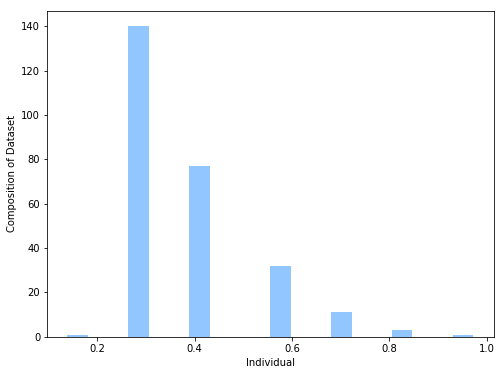

In [18]:
plt.style.use('seaborn-pastel')
plt.figure(figsize=(8, 6))
plt.hist(composition,bins='auto')
plt.xlabel("Individual")
plt.ylabel("Composition of Dataset")

In [79]:
image_arrays = []
image_labels = []

for label, individual in class_mapping.items():
    for directory in glob.glob(DATASET_DIRECTORY + '/*'):
        if directory.split("/")[1] == individual:
            image_directory = directory
            break
 
    for image in glob.glob(directory + '/*_CR.jpg'):
        image = plt.imread(image)
        image_arrays.append(image)
        image_labels.append(label)
        
    for image in glob.glob(directory + '/*_CR.JPG'):
        image = plt.imread(image)
        image_arrays.append(image)
        image_labels.append(label)
        
image_arrays = np.array(image_arrays)
image_labels = np.array(image_labels)
print(image_arrays.shape, image_labels.shape)

(720,) (720,)


# 2. InceptionV3 method

## 2.1 Training InceptionV3 model

In [31]:
# Fractions for each dataset
# These are not the real fractions as each individual has so few image samples
# True fractions are: 20% for testing set, 5% for validation set, and 75% for training set
train_frac = 0.30
valid_frac = 0.30
test_frac = 0.40
 
# This function takes in np arrays of images and labels along with split fractions
# and returns the six data arrays corresponding to each dataset as the appropriate type
def create_data_splits(X, y, class_images, train_frac=train_frac, test_frac=test_frac, valid_frac=valid_frac):
    X = np.array(X)
    y = np.array(y)
    # print(test_frac, valid_frac, train_frac)
 
    # Make sure that the fractions sum to 1.0
    assert (test_frac + valid_frac + train_frac == 1.0), "Test + Valid + Train Fractions must sum to 1.0"
    X_raw_test = []
    X_raw_valid = []
    X_raw_train = []
 
    y_raw_test = []
    y_raw_valid = []
    y_raw_train = []
 
 # Randomly order the data and labels
    random_indices = np.random.permutation(len(X))
    X = X[random_indices]
    y = y[random_indices]
 
    for image, label in zip(X, y):
 
    # Number of images that correspond to desired fraction
        test_length = math.floor(test_frac * class_images[label])
        valid_length = math.floor(valid_frac * class_images[label])
        # print(class_images[label])
 
        # Check to see if the datasets have the right number of labels (and images)
        if Counter(y_raw_valid)[label] < valid_length:
            X_raw_valid.append(np.array(image))
            y_raw_valid.append(label)
        elif Counter(y_raw_test)[label] < test_length:
            X_raw_test.append(np.array(image))
            y_raw_test.append(label)
        else:
            X_raw_train.append(np.array(image))
            y_raw_train.append(label)
    
    return X_raw_train, X_raw_valid, X_raw_test, y_raw_train, y_raw_valid, y_raw_test

In [32]:
# Create all the testing splits using the create_splits function
X_train, X_valid, X_test, y_train, y_valid, y_test = create_data_splits(image_arrays, image_labels, class_images)

In [33]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [34]:
# Check the number of images in each dataset split
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(533,) (48,) (139,)
(533,) (48,) (139,)


In [36]:
# Function takes in an image array and returns the resized and normalized array
def prepare_image(image, target_height=299, target_width=299):
    image = imresize(image, (target_width, target_height))
    return image.astype(np.float32) / 255

In [41]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 299, 299, 3], name='X')
is_training = tf.placeholder_with_default(False, [])
# Run inception function to determine endpoints
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=is_training)
# Create saver of network before alterations
inception_saver = tf.train.Saver()
# print(end_points)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [42]:
# Isolate the trainable layer
prelogits = tf.squeeze(end_points['PreLogits'], axis=[1,2])
# Define the training layer and the new output layer
n_outputs = len(class_mapping)
with tf.name_scope("new_output_layer"):
    people_logits = tf.layers.dense(prelogits, n_outputs, name="people_logits")
    probability = tf.nn.softmax(people_logits, name='probability')
# Placeholder for labels
y = tf.placeholder(tf.int32, None)
# Loss function and training operation
# The training operation is passed the variables to train which includes only the single layer
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=people_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
 # Single layer to be trained called "people_logits" (adapted from peoples' face recognition)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="people_logits")
 # The variables to train are passed to the training operation
    training_op = optimizer.minimize(loss, var_list=train_vars)

# Intialization function and saver
with tf.name_scope("init_and_saver"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.


To get the top-k accuracy, change the value of 'k'

In [43]:
# Accuracy for network evaluation
# Change the 'k' for top-k accuracy
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(predictions=people_logits, targets=y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [151]:
# Function takes in an array of images and labels and processes the images to create
# a batch of a given size
def create_batch(X, y, start_index=0, batch_size=4):

    stop_index = start_index + batch_size
    prepared_images = []
    labels = []
    
    for index in range(start_index, stop_index):
        prepared_images.append(prepare_image(X[index]))
        labels.append(y[index])
    
    # Combine the images into a single array by joining along the 0th axis
    X_batch = np.stack(prepared_images)
    # Combine the labels into a single array
    y_batch = np.array(labels, dtype=np.int32)

    return X_batch, y_batch

In [152]:
X_valid, y_valid = create_batch(X_valid, y_valid, 0, len(X_valid))
print(X_valid.shape, y_valid.shape)

/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


(15, 299, 299, 3) (15,)


In [154]:
with tf.name_scope("tensorboard_writing"):
    # Track validation accuracy and loss and training accuracy
    valid_acc_summary = tf.summary.scalar(name='valid_acc', tensor=accuracy)
    valid_loss_summary = tf.summary.scalar(name='valid_loss', tensor=loss)
    train_acc_summary = tf.summary.scalar(name='train_acc', tensor=accuracy)
    # Merge the validation stats
    valid_merged_summary = tf.summary.merge(inputs=[valid_acc_summary, valid_loss_summary])

# Specify the directory for the FileWriter
now = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = "{}_unaugmented".format(now)
logdir = "tensorboard/faces/" + model_dir
file_writer = tf.summary.FileWriter(logdir=logdir, graph=tf.get_default_graph())

In [161]:
n_epochs = 100
batch_size = 32
# Early stopping parameters
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.float("inf")
# Show progress every show_progress epochs
show_progress = 1
# Want to iterate through the entire training set every epoch
n_iterations_per_epoch = len(X_train) // batch_size
# Specify the directory for the FileWriter
now = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = "{}_unaugmented".format(now)
logdir = "tensorboard/faces/" + model_dir
file_writer = tf.summary.FileWriter(logdir=logdir, graph=tf.get_default_graph())
# This is the pre-trained model checkpoint training path
inception_v3_checkpoint_path = "models/cnn/inception_v3.ckpt"
# This is the checkpoint path for our trained model with no data augmentation
unaugmented_training_path = "models/cnn/inception_v3_faces_unaugmented.ckpt"
with tf.Session() as sess:
    init.run()
    # Restore all the weights from the original CNN
    inception_saver.restore(sess, inception_v3_checkpoint_path)
    t0 = time.time()
    for epoch in range(n_epochs):
        start_index = 0
        # Each epoch, iterate through all the training instances
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = create_batch(X_train, y_train, start_index, batch_size)
            # Train the trainable layer 
            sess.run(training_op, {X: X_batch, y: y_batch})
            start_index += batch_size
        # Display the progress of training and write to the TensorBoard directory
        # for later visualization of the training
        if epoch % show_progress == 0:
            train_summary = sess.run(train_acc_summary, {X: X_batch, y: y_batch})
            file_writer.add_summary(train_summary, (epoch+1))
        #Size for validation limited by GPU memory (68 images will work)
        valid_loss, valid_acc, valid_summary = sess.run([loss, accuracy, valid_merged_summary], {X: X_valid, y: y_valid})
        file_writer.add_summary(valid_summary, (epoch+1))
        print('Epoch: {:4} Validation Loss: {:.4f} Accuracy: {:4f}'.format(epoch+1, valid_loss, valid_acc))
        
        # Check to see if network is still improving, if improved during epoch
        # a snapshot of the model will be saved to retain the best model
        if valid_loss < best_loss:
            best_loss = valid_loss
            checks_without_progess = 0
            save_path = saver.save(sess, unaugmented_training_path)
 
 # If network is not improving for a specified number of epochs, stop training
        else:
            checks_without_progress += 1
        if checks_without_progress > max_checks_without_progress:
            print('Stopping Early! Loss has not improved in {} epochs'.format(max_checks_without_progress))
            break
    
    t1 = time.time()
    print('Total Training Time: {:.2f} minutes'.format( (t1-t0) / 60))

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt


/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


Epoch:    1 Validation Loss: 9.3541 Accuracy: 0.066667
Epoch:    2 Validation Loss: 5.8829 Accuracy: 0.266667
Epoch:    3 Validation Loss: 6.5852 Accuracy: 0.200000
Epoch:    4 Validation Loss: 6.8330 Accuracy: 0.266667
Epoch:    5 Validation Loss: 6.3995 Accuracy: 0.266667
Epoch:    6 Validation Loss: 5.6800 Accuracy: 0.200000
Epoch:    7 Validation Loss: 5.1911 Accuracy: 0.333333
Epoch:    8 Validation Loss: 5.1228 Accuracy: 0.266667
Epoch:    9 Validation Loss: 5.2633 Accuracy: 0.266667
Epoch:   10 Validation Loss: 4.8052 Accuracy: 0.266667
Epoch:   11 Validation Loss: 5.6382 Accuracy: 0.200000
Epoch:   12 Validation Loss: 4.7746 Accuracy: 0.400000
Epoch:   13 Validation Loss: 4.7187 Accuracy: 0.333333
Epoch:   14 Validation Loss: 4.6658 Accuracy: 0.333333
Epoch:   15 Validation Loss: 4.6135 Accuracy: 0.333333
Epoch:   16 Validation Loss: 4.6188 Accuracy: 0.400000
Epoch:   17 Validation Loss: 4.6304 Accuracy: 0.400000
Epoch:   18 Validation Loss: 4.6416 Accuracy: 0.400000
Epoch:   1

In [168]:
eval_batch_size = 11

n_iterations = len(X_test) // eval_batch_size
with tf.Session() as sess:
    # Restore the new trained model 
    saver.restore(sess, unaugmented_training_path)
    
    start_index = 0
    # Create a dictionary to store all the accuracies
    test_acc = {}
    
    t0 = time.time()
    # Iterate through entire testing set one batch at a time
    for iteration in range(n_iterations):
        X_test_batch, y_test_batch = create_batch(X_test, y_test, start_index, batch_size=eval_batch_size)
        test_acc[iteration] = accuracy.eval({X: X_test_batch, y:y_test_batch})
        start_index += eval_batch_size
        print('Iteration: {} Batch Testing Accuracy: {:.2f}%'.format(iteration+1, test_acc[iteration] * 100))
    
    t1 = time.time()
    
# Final accuracy is mean of each batch accuracy
print('\nFinal Testing Accuracy: {:.4f}% on {} instances.'.format(np.mean(list(test_acc.values())) * 100, len(X_test)))
print('Total evaluation time: {:.4f} seconds'.format((t1-t0)))

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3_faces_unaugmented.ckpt


/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


Iteration: 1 Batch Testing Accuracy: 36.36%
Iteration: 2 Batch Testing Accuracy: 27.27%
Iteration: 3 Batch Testing Accuracy: 18.18%
Iteration: 4 Batch Testing Accuracy: 27.27%

Final Testing Accuracy: 27.2727% on 48 instances.
Total evaluation time: 4.8221 seconds


# 2.2 Data augmentation

In [169]:
# Take in an image as an array and return image with a [dx, dy] shift
def shift_image(image_array, shift):
    return scipy.ndimage.interpolation.shift(image_array, shift, cval=0)
# Four shifts of 30 pixels 
shifts = [[30,0], [-30,0], [0, 30], [0,-30]]
shifted_images = []
shifted_labels = []

In [171]:
# Iterate through all training images
for image, label in zip(X_train, y_train):
    # Swap the color channel and height axis 
    layers = np.swapaxes(image, 0, 2)
    # Apply four shifts to each original image
    for shift in shifts:
        transposed_image_layers = []
        # Apply the shift to the image one layer at a time
        # Each layer is an RGB color channel
        for layer in layers:
            transposed_image_layers.append(shift_image(layer, shift))
            # Stack the RGB layers to get one image and reswap the axes
        transposed_image = np.stack(transposed_image_layers)
        transposed_image = np.swapaxes(transposed_image, 0, 2)
        # Add the shifted images and the labels to a list
        shifted_images.append(transposed_image)
        shifted_labels.append(label)
# Convert the images and labels to numpy arrays
shifted_images = np.array(shifted_images)
shifted_labels = np.array(shifted_labels)
print(shifted_images.shape,shifted_labels.shape)

(5017,) (5017,)


In [181]:
shifted_images_test = []
shifted_labels_test = []
# Iterate through all training images
for image, label in zip(X_test, y_test):
    # Swap the color channel and height axis 
    layers = np.swapaxes(image, 0, 2)
    # Apply four shifts to each original image
    for shift in shifts:
        transposed_image_layers = []
        # Apply the shift to the image one layer at a time
        # Each layer is an RGB color channel
        for layer in layers:
            transposed_image_layers.append(shift_image(layer, shift))
            # Stack the RGB layers to get one image and reswap the axes
        transposed_image = np.stack(transposed_image_layers)
        transposed_image = np.swapaxes(transposed_image, 0, 2)
        # Add the shifted images and the labels to a list
        shifted_images_test.append(transposed_image)
        shifted_labels_test.append(label)
# Convert the images and labels to numpy arrays
shifted_images_test = np.array(shifted_images_test)
shifted_labels_test = np.array(shifted_labels_test)
print(shifted_images_test.shape,shifted_labels_test.shape)

(192,) (192,)


In [173]:
# Function to plot an array of RGB values 
def plot_color_image(image):
    plt.figure(figsize=(4,4))
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.axis('off')

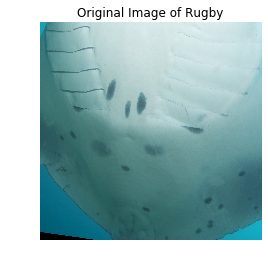

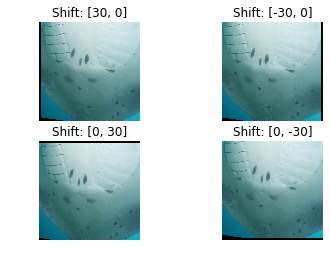

In [174]:
ex_index = 5
# Plot original image
plot_color_image(X_train[ex_index])
plt.title("Original Image of {}".format(class_mapping[y_train[ex_index]]))
plt.show()
ex_shifted_images = shifted_images[ex_index*4:(ex_index*4)+ 4]
# Plot four shifted images
for i, image in enumerate(ex_shifted_images):
    shift = shifts[i]
    plt.subplot(2,2,i+1)
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.title('Shift: {}'.format(shift))
    plt.axis('off')
plt.show()

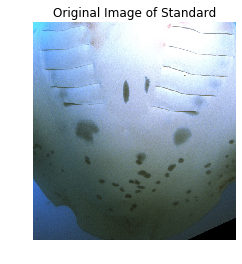

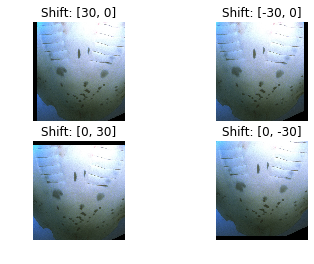

In [177]:
ex_index = 2
# Plot original image
plot_color_image(X_train[ex_index])
plt.title("Original Image of {}".format(class_mapping[y_train[ex_index]]))
plt.show()
ex_shifted_images = shifted_images[ex_index*4:(ex_index*4)+ 4]
# Plot four shifted images
for i, image in enumerate(ex_shifted_images):
    shift = shifts[i]
    plt.subplot(2,2,i+1)
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.title('Shift: {}'.format(shift))
    plt.axis('off')
plt.show()

In [199]:
images_flipped = []
labels_flipped = [] 

# Flip every image in the training set
for image, label in zip(X_test, y_test):
    images_flipped.append(np.fliplr(image))
    labels_flipped.append(label)

# Convert the flipped images and labels to arrays
images_flipped = np.array(images_flipped)
labels_flipped = np.array(labels_flipped)

In [454]:
class_mapping[y_train[ex_index]]

'Moby Dick'

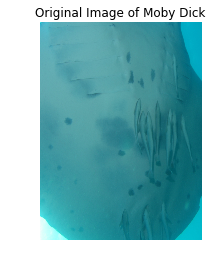

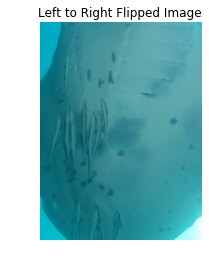

In [201]:
ex_index = 22

plot_color_image(X_test[ex_index])
plt.title('Original Image of {}'.format(class_mapping[y_train[ex_index]]))
plt.show()

plot_color_image(images_flipped[ex_index])
plt.title('Left to Right Flipped Image')
plt.show()

In [178]:
# Create a new training set with the original and shifted images
X_train_exp = np.concatenate((shifted_images, X_train))
y_train_exp = np.concatenate((shifted_labels, y_train))

In [182]:
# Create a new test set with the original and shifted images
X_test_exp = np.concatenate((shifted_images_test, X_test))
y_test_exp = np.concatenate((shifted_labels_test, y_test))

In [179]:
# Randomize the order of the trained shifted images
random_indices = np.random.permutation(len(X_train_exp))

X_train_exp = X_train_exp[random_indices]
y_train_exp = y_train_exp[random_indices]

In [183]:
# Randomize the order of the test shifted images
random_indices = np.random.permutation(len(X_test_exp))

X_test_exp = X_test_exp[random_indices]
y_test_exp = y_test_exp[random_indices]

In [202]:
# Create a new test set with the original and flipped images
X_test_with_flip = np.concatenate((X_test, images_flipped))
y_test_with_flip = np.concatenate((y_test, labels_flipped))

## Evaluation

In [423]:
eval_batch_size = 11
n_iterations = len(X_test) // eval_batch_size

with tf.Session() as sess:
    saver.restore(sess, unaugmented_training_path)
    
    start_index = 0
    test_acc = {}
    t0 = time.time()
    
    for iteration in range(n_iterations):
        X_test_batch, y_test_batch = create_batch(X_test, y_test, start_index=start_index, batch_size=eval_batch_size)
        test_acc[iteration] = accuracy.eval({X: X_test_batch, y:y_test_batch})
        start_index += eval_batch_size

        print('Iteration: {} Batch Testing Accuracy: {:.2f}%'.format(
            iteration+1, test_acc[iteration] * 100))
    t1 = time.time()
    
    print('\nFinal Unaugmented with Clean Start Testing Accuracy: {:.4f}% on {} instances.'.format(
        np.mean(list(test_acc.values())) * 100, len(X_test)))
    
    print('Evaluation Time: {:.2f} seconds'.format( (t1 - t0)))

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3_faces_unaugmented.ckpt


/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


Iteration: 1 Batch Testing Accuracy: 90.91%
Iteration: 2 Batch Testing Accuracy: 90.91%
Iteration: 3 Batch Testing Accuracy: 90.91%
Iteration: 4 Batch Testing Accuracy: 81.82%

Final Unaugmented with Clean Start Testing Accuracy: 88.6364% on 48 instances.
Evaluation Time: 5.17 seconds


In [424]:
eval_batch_size = 11
n_iterations = len(X_test_exp) // eval_batch_size

with tf.Session() as sess:
    saver.restore(sess, unaugmented_training_path)
    
    start_index = 0
    test_acc = {}
    t0 = time.time()
    
    for iteration in range(n_iterations):
        X_test_batch, y_test_batch = create_batch(X_test_exp, y_test_exp, start_index=start_index, batch_size=eval_batch_size)
        test_acc[iteration] = accuracy.eval({X: X_test_batch, y:y_test_batch})
        start_index += eval_batch_size

        print('Iteration: {} Batch Testing Accuracy: {:.2f}%'.format(
            iteration+1, test_acc[iteration] * 100))
    t1 = time.time()
    
    print('\nFinal Unaugmented with Clean Start Testing Accuracy: {:.4f}% on {} instances.'.format(
        np.mean(list(test_acc.values())) * 100, len(X_test_exp)))
    
    print('Evaluation Time: {:.2f} seconds'.format( (t1 - t0)))

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3_faces_unaugmented.ckpt


/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


Iteration: 1 Batch Testing Accuracy: 90.91%
Iteration: 2 Batch Testing Accuracy: 90.91%
Iteration: 3 Batch Testing Accuracy: 90.91%
Iteration: 4 Batch Testing Accuracy: 90.91%
Iteration: 5 Batch Testing Accuracy: 72.73%
Iteration: 6 Batch Testing Accuracy: 90.91%
Iteration: 7 Batch Testing Accuracy: 81.82%
Iteration: 8 Batch Testing Accuracy: 81.82%
Iteration: 9 Batch Testing Accuracy: 100.00%
Iteration: 10 Batch Testing Accuracy: 100.00%
Iteration: 11 Batch Testing Accuracy: 81.82%
Iteration: 12 Batch Testing Accuracy: 81.82%
Iteration: 13 Batch Testing Accuracy: 81.82%
Iteration: 14 Batch Testing Accuracy: 90.91%
Iteration: 15 Batch Testing Accuracy: 81.82%
Iteration: 16 Batch Testing Accuracy: 81.82%
Iteration: 17 Batch Testing Accuracy: 72.73%
Iteration: 18 Batch Testing Accuracy: 81.82%
Iteration: 19 Batch Testing Accuracy: 90.91%
Iteration: 20 Batch Testing Accuracy: 90.91%
Iteration: 21 Batch Testing Accuracy: 63.64%

Final Unaugmented with Clean Start Testing Accuracy: 85.2814%

In [425]:
eval_batch_size = 11
n_iterations = len(X_test_with_flip) // eval_batch_size

with tf.Session() as sess:
    saver.restore(sess, unaugmented_training_path)
    
    start_index = 0
    test_acc = {}
    t0 = time.time()
    
    for iteration in range(n_iterations):
        X_test_batch, y_test_batch = create_batch(X_test_with_flip, y_test_with_flip, start_index=start_index, batch_size=eval_batch_size)
        test_acc[iteration] = accuracy.eval({X: X_test_batch, y:y_test_batch})
        start_index += eval_batch_size

        print('Iteration: {} Batch Testing Accuracy: {:.2f}%'.format(
            iteration+1, test_acc[iteration] * 100))
    t1 = time.time()
    
    print('\nFinal Unaugmented with Clean Start Testing Accuracy: {:.4f}% on {} instances.'.format(
        np.mean(list(test_acc.values())) * 100, len(X_test_with_flip)))
    
    print('Evaluation Time: {:.2f} seconds'.format( (t1 - t0)))

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3_faces_unaugmented.ckpt


/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


Iteration: 1 Batch Testing Accuracy: 90.91%
Iteration: 2 Batch Testing Accuracy: 90.91%
Iteration: 3 Batch Testing Accuracy: 90.91%
Iteration: 4 Batch Testing Accuracy: 81.82%
Iteration: 5 Batch Testing Accuracy: 81.82%
Iteration: 6 Batch Testing Accuracy: 100.00%
Iteration: 7 Batch Testing Accuracy: 90.91%
Iteration: 8 Batch Testing Accuracy: 81.82%

Final Unaugmented with Clean Start Testing Accuracy: 88.6364% on 96 instances.
Evaluation Time: 10.51 seconds


In [206]:
# recognize a sample image and get predictions
def classify_image(index, images=X_test, labels=y_test):
    image_array = images[index]
    label = class_mapping[labels[index]]
    
    prepared_image = prepare_image(image_array)
    prepared_image = np.reshape(prepared_image, newshape=(-1, 299, 299, 3))
    
    with tf.Session() as sess:
        saver.restore(sess, unaugmented_training_path)
        predictions = sess.run(probability, {X: prepared_image})
    
    predictions = [(i, prediction) for i, prediction in enumerate(predictions[0])]
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
    print('\nCorrect Answer: {}'.format(label)) 
    print('\nPredictions:')
    for prediction in predictions:
        class_label = prediction[0]
        probability_value = prediction[1]
        label = class_mapping[class_label]
        print("{:26}: {:.2f}%".format(label, probability_value * 100))
        
    plot_color_image(image_array)
    return predictions

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3_faces_unaugmented.ckpt


/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.



Correct Answer: Galaxy

Predictions:
Seven                     : 17.18%
Butterfly                 : 13.50%
High 5                    : 7.41%
Cookie                    : 7.41%
Frank                     : 5.84%
Daniela                   : 3.96%
Prancer                   : 3.69%
Compass                   : 3.52%
Alice                     : 3.01%
Headlights                : 2.93%
Penguin                   : 2.21%
Chicken Little            : 1.90%
Atomic                    : 1.89%
Maia                      : 1.83%
Button                    : 1.76%
Faith                     : 1.34%
Crayfish                  : 1.32%
Tazer                     : 1.24%
Tri-Star                  : 1.11%
Woman                     : 0.98%
Babe Ruth                 : 0.96%
Lick                      : 0.91%
Emily                     : 0.71%
Bowtie                    : 0.68%
Changeling                : 0.64%
Blah                      : 0.60%
2nd Go                    : 0.59%
Galaxy                    : 0.58%
Arnulv  

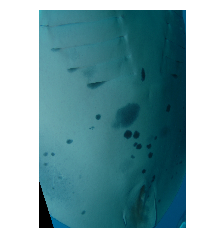

In [360]:
predictions = classify_image(13)

# 3. Extract features from CNN and train SVM

In [240]:
model_dir = 'imagenet'
list_images = []

for label, individual in class_mapping.items():
    for directory in glob.glob(DATASET_DIRECTORY + '/*'):
        if directory.split("/")[1] == individual:
            image_directory = directory
            break
 
    for image in glob.glob(directory + '/*_CR.jpg'):
        list_images.append(image)
        
    for image in glob.glob(directory + '/*_CR.JPG'):
        list_images.append(image)

In [241]:
list_images[0]

'MantaRay/Heartbreaker/Heartbreaker Zavora 2010_CR.JPG'

In [243]:
def create_graph():
    with gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [262]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

        for ind, image in enumerate(list_images):
            if (ind%100 == 0):
                print('Processing %s...' % (image))
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s', image)

            image_data = gfile.FastGFile(image, 'rb').read()
            predictions = sess.run(next_to_last_tensor,
            {'DecodeJpeg/contents:0': image_data})
            features[ind,:] = np.squeeze(predictions)
            labels.append(re.split('_\d+',image.split('/')[1])[0])
            #print(re.split('_\d+',image.split('/')[1])[0])

    return features, labels

In [263]:
features,labels = extract_features(list_images)

Processing MantaRay/Heartbreaker/Heartbreaker Zavora 2010_CR.JPG...
Processing MantaRay/C-Section/C-section 2009_CR.JPG...
Processing MantaRay/X-Ray/X-Ray 4_CR.JPG...
Processing MantaRay/Frank/Frank 2008_CR.jpg...
Processing MantaRay/Confetti/Confetti wingscars_CR.JPG...
Processing MantaRay/Yoko/Yoko 1_CR.JPG...
Processing MantaRay/Floppy/Floppy_CR.JPG...
Processing MantaRay/Carrot/Carrot 2008_CR.JPG...


In [266]:
pickle.dump(features, open('features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))

In [271]:
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [272]:
clf = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf.fit(svm_X_train, svm_y_train)
svm_y_pred = clf.predict(svm_X_test)

/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [275]:
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size

Accuracy: 27.1%


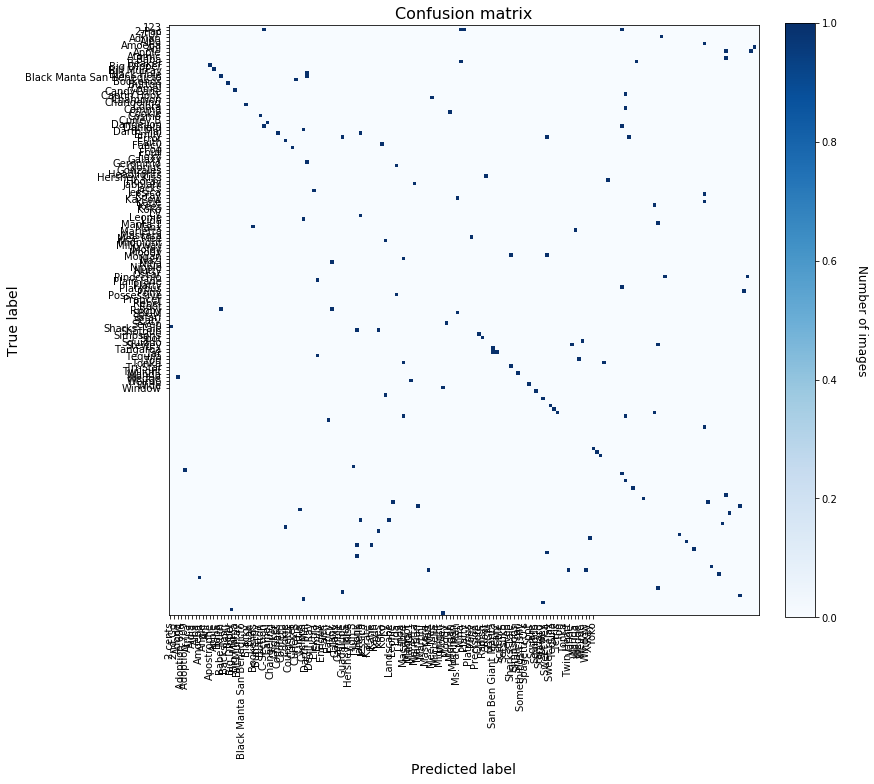

In [276]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(svm_y_test,svm_y_pred)*100))
plot_confusion_matrix(svm_y_test,svm_y_pred)

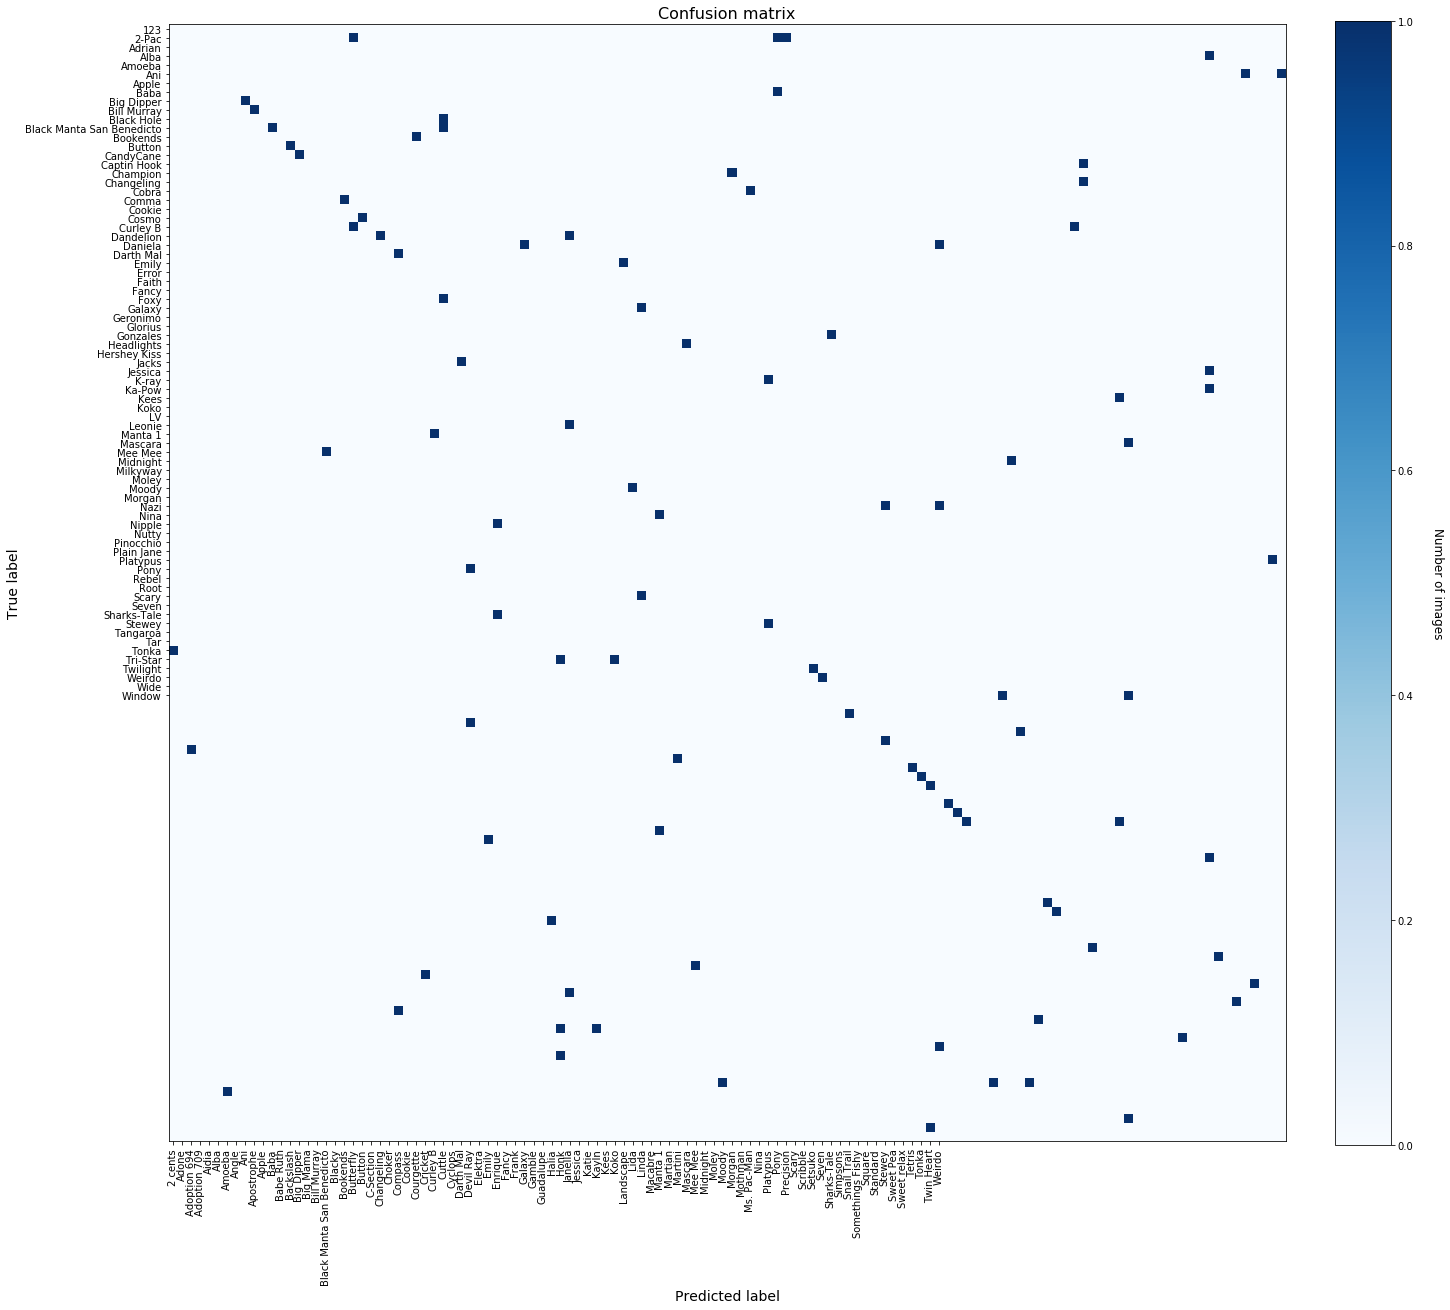

In [278]:
plot_confusion_matrix(svm_y_test[:100],svm_y_pred[:100])

# 4. Visualizing CNN features

In [66]:
IMG_SIZE = (299, 299, 3)
BATCH_SIZE = 16

In [67]:
inp = Input(IMG_SIZE)
inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp, input_shape=IMG_SIZE, pooling='avg')

In [68]:
x = inception.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
out = Dense(5, activation='softmax')(x)

In [69]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (299, 299, 3))

In [70]:
base_model.load_weights("inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [73]:
images = []
for i in image_arrays:
    new_image = i
    image = imresize(i, (299, 299))
    image = image.astype(np.float32) / 255
    #print(image.shape)
    images.append(image)

new_image_arrays = np.stack(images, axis=0)

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

predictions = Dense(1, activation='sigmoid',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

model= Model(inputs=base_model.input, outputs=predictions)

/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


In [74]:
model.load_weights("Inceptionv3_2.h5")
model_origin = InceptionV3(weights='imagenet',include_top=False,input_shape = (299, 299, 3))
# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = -1
print("Remove Activation from Last Layer")
# Swap softmax with linear
model_origin.layers[layer_idx].activation = activations.linear
print("Done. Now Applying changes to the model ...")
model_origin = utils.apply_modifications(model_origin)

Remove Activation from Last Layer
Done. Now Applying changes to the model ...


/Users/zhuonijie/.virtualenvs/cv2/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [75]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [91]:
import keras.preprocessing.image as image

im_file = image_paths[12]
img1 = image.load_img(im_file, target_size=(299,299))
img1 = image.img_to_array(img1)
img1 = np.expand_dims(img1, axis=0)
#img1 = new_image_arrays[0]
img1 = preprocess_input(img1)
layer_idx = utils.find_layer_idx(model, 'activation_99')
heatmap = visualize_cam(model, layer_idx, filter_indices=24, seed_input=img1[0,:,:,:])

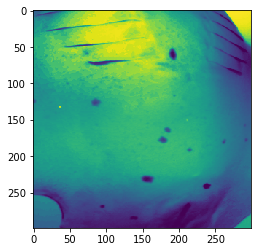

In [92]:
img_init= utils.load_img(im_file,target_size=(299,299))
heatmap = imresize(heatmap, [299,299])
plt.imshow(img_init)
plt.show()

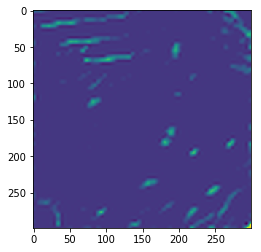

In [93]:
plt.imshow(heatmap)
plt.show()

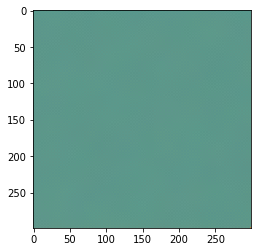

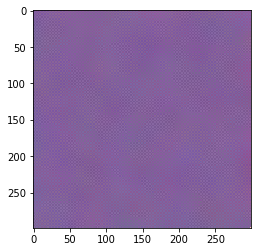

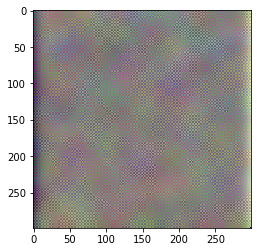

In [95]:
layer_name="conv2d_95" # visualize conv layer
layer_idx = utils.find_layer_idx(model, layer_name)

for filter_idx in [0,10,20]:
    visu=visualize_activation(model,layer_idx,filter_indices=filter_idx)
    plt.imshow(visu)
    plt.show()

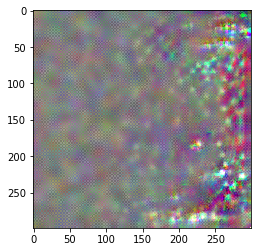

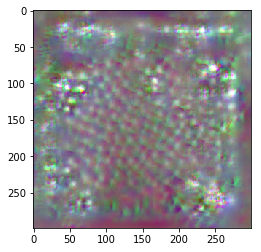

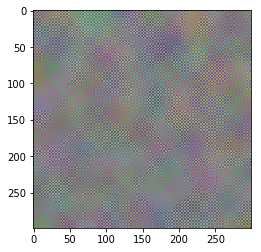

In [96]:
layer_name="max_pooling2d_8"
layer_idx = utils.find_layer_idx(model, layer_name)

for filter_idx in [0,10,20]:
    visu=visualize_activation(model,layer_idx,filter_indices=filter_idx)
    plt.imshow(visu)
    plt.show()

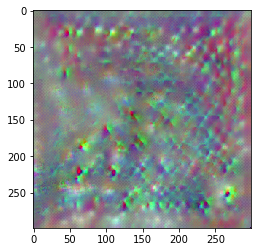

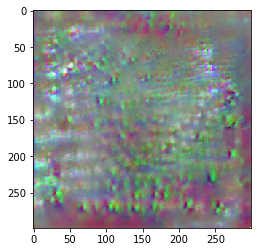

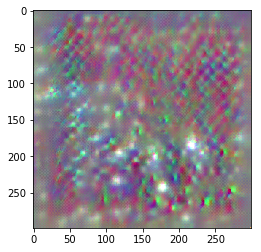

In [97]:
layer_name="conv2d_180"
layer_idx = utils.find_layer_idx(model, layer_name)

for filter_idx in [0,10,20]:
    visu=visualize_activation(model,layer_idx,filter_indices=filter_idx)
    plt.imshow(visu)
    plt.show()

# 4. ORB & SIFT matching visualization

In [48]:
img1 = plt.imread('MantaRay/Cobra/Cobra spots_CR.jpg') # queryImage
img2 = plt.imread('MantaRay/Cobra/Cobra_CR.JPG') # trainImage

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

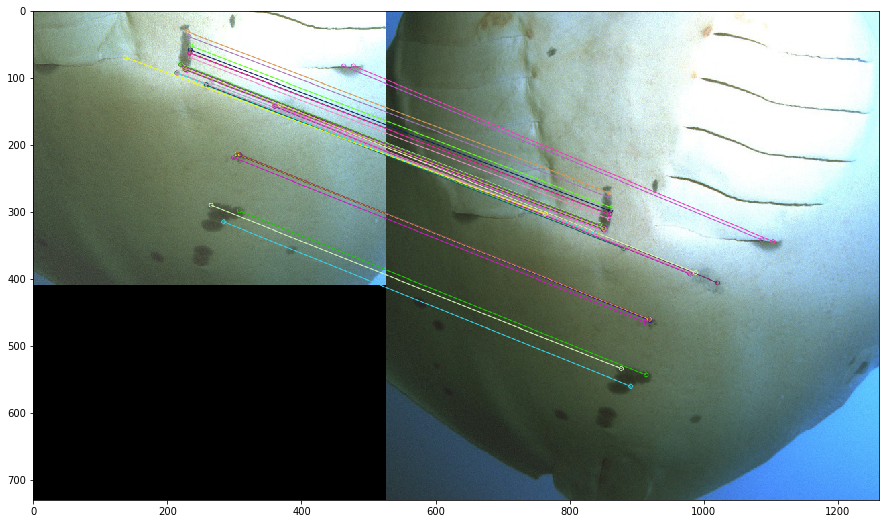

(<matplotlib.image.AxesImage at 0x2de656940>, None)

In [55]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:40],None,flags=2)

plt.figure(figsize=(16, 9))
plt.imshow(img3),plt.show()

In [56]:
MIN_MATCH_COUNT = 2
img1 = plt.imread('MantaRay/Cobra/Cobra spots_CR.jpg')          # queryImage
img2 = plt.imread('MantaRay/Cobra/Cobra_CR.JPG') # trainImage
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [57]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

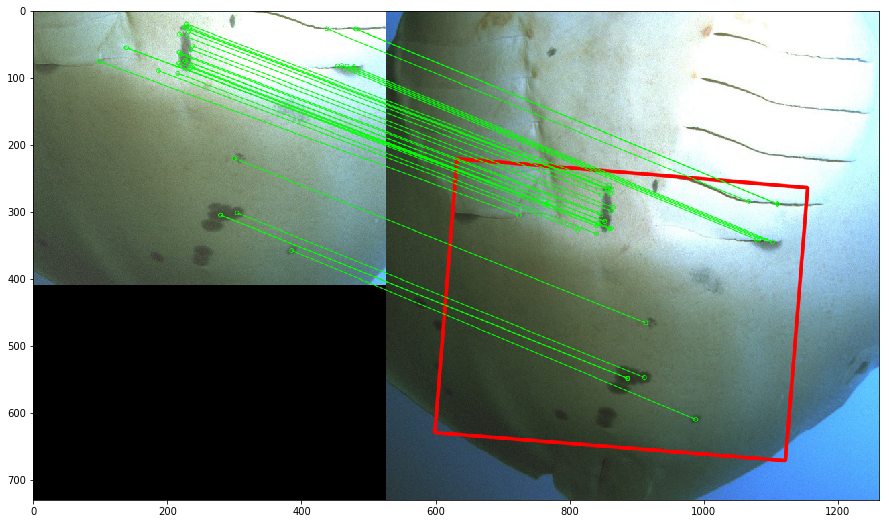

(<matplotlib.image.AxesImage at 0x2dc643da0>, None)

In [59]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(16, 9))
plt.imshow(img3, 'gray'),plt.show()

In [455]:
img1 = cv.imread('/users/zhuonijie/Desktop/slim/MantaRay/Gonzales/Gonzales 1_EH.JPG',0)
img2 = cv.imread('/users/zhuonijie/Desktop/slim/MantaRay/Gonzales/Gonzales 2_EH.JPG',0)

-0.0019090479472652078


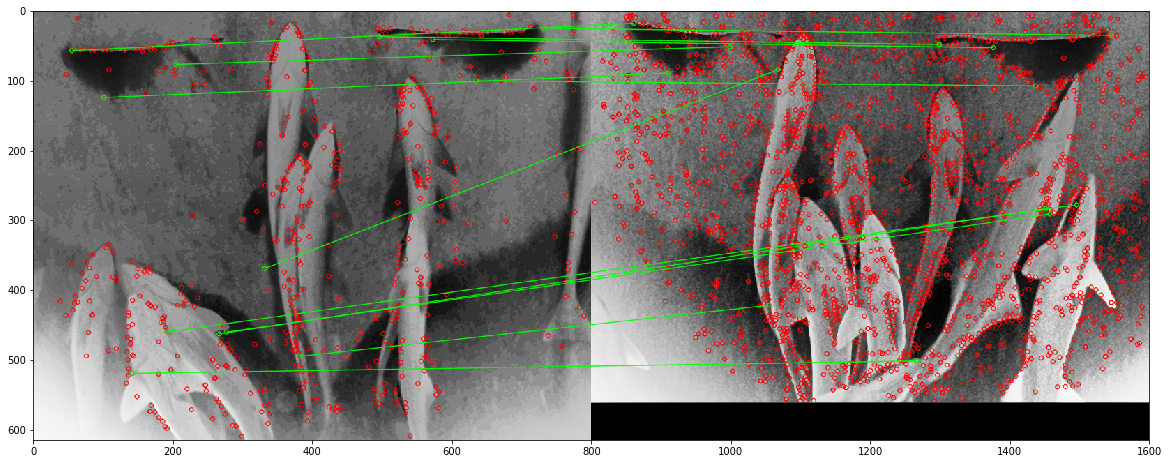

(<matplotlib.image.AxesImage at 0x98d53fdd8>, None)

In [456]:
import timeit

start = timeit.timeit()
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
end = timeit.timeit()
print (end - start)
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()